# Preliminaries

In this section, we gather the code provided to us.

In [38]:
# %load mlmc.py
import numpy
import numpy.linalg
import timeit
import sys
from math import sqrt
import matplotlib.pyplot as plt

class WeakConvergenceFailure(Exception):
    pass

def mlmc(Lmin, Lmax, N0, eps, mlmc_fn, alpha_0, beta_0, gamma):
    """
    Multi-level Monte Carlo estimation.

    (P, Nl) = mlmc(...)

    Outputs:
      P:  value
      Nl: number of samples on each level
    Inputs:
      Lmin: minimum level of refinement  >= 2
      Lmax: maximum level of refinement  >= Lmin
      N0:   initial number of samples    >  0
      eps:  desired accuracy (rms error) >  0

      alpha: weak error is  O(2^{-alpha*l})
      beta:  variance is    O(2^{-beta*l})
      gamma: sample cost is O(2^{gamma*l})  > 0

      If alpha, beta are not positive then they will be estimated.

      mlmc_fn: the user low-level routine. Its interface is
        sums = mlmc_fn(l, N)
      with inputs
        l = level
        N = number of paths
      and a numpy array of outputs
        sums[0] = sum(Y)
        sums[1] = sum(Y**2)
      where Y are iid samples with expected value
        E[P_0]            on level 0
        E[P_l - P_{l-1}]  on level l > 0
    """

    # Check arguments

    if Lmin < 2:
        raise ValueError("Need Lmin >= 2")
    if Lmax < Lmin:
        raise ValueError("Need Lmax >= Lmin")
    if N0 <= 0 or eps <= 0 or gamma <= 0:
        raise ValueError("Need N0 > 0, eps > 0, gamma > 0")

    # Initialisation

    alpha = max(0, alpha_0)
    beta  = max(0, beta_0)

    theta = 0.25

    L = Lmin

    Nl   = numpy.zeros(L+1)
    suml = numpy.zeros((2, L+1))
    dNl  = N0*numpy.ones(L+1)

    while sum(dNl) > 0:

        # update sample sums

        for l in range(0, L+1):
            if dNl[l] > 0:
                sums       = mlmc_fn(l, int(dNl[l]))
                Nl[l]      = Nl[l] + dNl[l]
                suml[0, l] = suml[0, l] + sums[0]
                suml[1, l] = suml[1, l] + sums[1]

        # compute absolute average and variance

        ml = numpy.abs(       suml[0, :]/Nl)
        Vl = numpy.maximum(0, suml[1, :]/Nl - ml**2)

        # fix to cope with possible zero values for ml and Vl
        # (can happen in some applications when there are few samples)

        for l in range(3, L+2):
            ml[l-1] = max(ml[l-1], 0.5*ml[l-2]/2**alpha)
            Vl[l-1] = max(Vl[l-1], 0.5*Vl[l-2]/2**beta)

        # use linear regression to estimate alpha, beta if not given
        if alpha_0 <= 0:
            A = numpy.ones((L, 2)); A[:, 0] = range(1, L+1)
            x = numpy.linalg.solve(A, numpy.log2(ml[1:]))
            alpha = max(0.5, -x[0])

        if beta_0 <= 0:
            A = numpy.ones((L, 2)); A[:, 0] = range(1, L+1)
            x = numpy.linalg.solve(A, numpy.log2(Vl[1:]))
            beta = max(0.5, -x[0])

        # set optimal number of additional samples

        Cl = 2**(gamma*numpy.arange(0, L+1))
        Ns = numpy.ceil( numpy.sqrt(Vl/Cl) * sum(numpy.sqrt(Vl*Cl)) / ((1-theta)*eps**2) )
        dNl = numpy.maximum(0, Ns-Nl)

        # if (almost) converged, estimate remaining error and decide
        # whether a new level is required

        if sum(dNl > 0.01*Nl) == 0:
            rem = ml[L] / (2.0**alpha - 1.0)

            if rem > numpy.sqrt(theta)*eps:
                if L == Lmax:
                    raise WeakConvergenceFailure("Failed to achieve weak convergence")
                else:
                    L = L + 1
                    Vl = numpy.append(Vl, Vl[-1] / 2.0**beta)
                    Nl = numpy.append(Nl, 0.0)
                    suml = numpy.column_stack([suml, [0, 0]])

                    Cl = 2**(gamma*numpy.arange(0, L+1))
                    Ns = numpy.ceil( numpy.sqrt(Vl/Cl) * sum(numpy.sqrt(Vl*Cl)) / ((1-theta)*eps**2) )
                    dNl = numpy.maximum(0, Ns-Nl)

    # finally, evaluate the multilevel estimator
    P = sum(suml[0,:]/Nl)

    return (P, Nl)


def mlmc_test(mlmc_fn, M, N, L, N0, Eps, Lmin, Lmax, logfile):
    """
    Multilevel Monte Carlo test routine.

    mlmc_fn: the user low-level routine. Its interface is
      sums = mlmc_fn(l, N)
    with inputs
      l = level
      N = number of paths
    and a numpy array of outputs
      sums[0] = sum(Pf-Pc)
      sums[1] = sum((Pf-Pc)**2)
      sums[2] = sum((Pf-Pc)**3)
      sums[3] = sum((Pf-Pc)**4)
      sums[4] = sum(Pf)
      sums[5] = sum(Pf**2)

    M: refinement cost factor (2**gamma in general MLMC theorem)

    N: number of samples for convergence tests
    L: number of levels for convergence tests

    N0: initial number of samples for MLMC calculations
    Eps: desired accuracy array for MLMC calculations
    """

    # First, convergence tests

    write(logfile, "\n")
    write(logfile, "**********************************************************\n")
    write(logfile, "*** Convergence tests, kurtosis, telescoping sum check ***\n")
    write(logfile, "**********************************************************\n")
    write(logfile, "\n l   ave(Pf-Pc)    ave(Pf)   var(Pf-Pc)    var(Pf)")
    write(logfile, "    kurtosis     check \n-------------------------")
    write(logfile, "--------------------------------------------------\n")

    del1 = []
    del2 = []
    var1 = []
    var2 = []
    kur1 = []
    chk1 = []
    cost = []

    for l in range(0, L+1):
        tic = timeit.default_timer()
        sums = mlmc_fn(l, N)
        toc = timeit.default_timer()
        cost.append(toc - tic)
        sums = sums/N

        if l == 0:
            kurt = 0.0
        else:
            kurt = (     sums[3]
                     - 4*sums[2]*sums[0]
                     + 6*sums[1]*sums[0]**2
                     - 3*sums[0]*sums[0]**3 ) / (sums[1]-sums[0]**2)**2

        del1.append(sums[0])
        del2.append(sums[4])
        var1.append(sums[1]-sums[0]**2)
        var2.append(max(sums[5]-sums[4]**2, 1.0e-10)) # fix for cases with var = 0
        kur1.append(kurt)

        if l == 0:
            check = 0
        else:
            check =          abs(       del1[l]  +      del2[l-1]  -      del2[l])
            check = check / ( 3.0*(sqrt(var1[l]) + sqrt(var2[l-1]) + sqrt(var2[l]) )/sqrt(N))
        chk1.append(check)

        write(logfile, "%2d   %8.4e  %8.4e  %8.4e  %8.4e  %8.4e  %8.4e \n" % \
                      (l, del1[l], del2[l], var1[l], var2[l], kur1[l], chk1[l]))

    if kur1[-1] > 100.0:
        write(logfile, "\n WARNING: kurtosis on finest level = %f \n" % kur1[-1]);
        write(logfile, " indicates MLMC correction dominated by a few rare paths; \n");
        write(logfile, " for information on the connection to variance of sample variances,\n");
        write(logfile, " see http://mathworld.wolfram.com/SampleVarianceDistribution.html\n\n");

    if max(chk1) > 1.0:
        write(logfile, "\n WARNING: maximum consistency error = %f \n" % max(chk1))
        write(logfile, " indicates identity E[Pf-Pc] = E[Pf] - E[Pc] not satisfied \n\n")

    L1 = int(numpy.ceil(0.4*L));
    L2 = L+1;
    pa    = numpy.polyfit(range(L1+1, L2+1), numpy.log2(numpy.abs(del1[L1:L2])), 1);  alpha = -pa[0];
    pb    = numpy.polyfit(range(L1+1, L2+1), numpy.log2(numpy.abs(var1[L1:L2])), 1);  beta  = -pb[0];
    gamma = numpy.log2(cost[-1]/cost[-2]);

    write(logfile, "\n******************************************************\n");
    write(logfile, "*** Linear regression estimates of MLMC parameters ***\n");
    write(logfile, "******************************************************\n");
    write(logfile, "\n alpha = %f  (exponent for MLMC weak convergence)\n" % alpha);
    write(logfile, " beta  = %f  (exponent for MLMC variance) \n" % beta);
    write(logfile, " gamma = %f  (exponent for MLMC cost) \n" % gamma);

    # Second, MLMC complexity tests

    write(logfile, "\n");
    write(logfile, "***************************** \n");
    write(logfile, "*** MLMC complexity tests *** \n");
    write(logfile, "***************************** \n\n");
    write(logfile, "  eps   mlmc_cost   std_cost  savings     N_l \n");
    write(logfile, "----------------------------------------------- \n");

    gamma = numpy.log2(M)
    theta = 0.25

    for eps in Eps:
       (P, Nl) = mlmc(Lmin, Lmax, N0, eps, mlmc_fn, alpha, beta, gamma)
       l = len(Nl) - 1
       mlmc_cost = (1 + 1.0/M)*sum(Nl * M**numpy.arange(0, l+1))
       std_cost  = sum(var2[-1]*M**numpy.arange(0, l+1))/((1.0 -theta)*eps**2)

       write(logfile, "%.4f  %.3e  %.3e  %7.2f " % (eps, mlmc_cost, std_cost, std_cost/mlmc_cost))
       write(logfile, " ".join(["%9d" % n for n in Nl]))
       write(logfile, "\n")

    write(logfile, "\n")

def write(logfile, msg):
    """
    Write to both sys.stdout and to a logfile.
    """
    logfile.write(msg)
    sys.stdout.write(msg)
    
def mlmc_plot(filename, nvert):

    file = open(filename, "r")

    # Declare lists for data
    del1 = []
    del2 = []
    var1 = []
    var2 = []
    kur1 = []
    chk1 = []
    l    = []

    epss = []
    mlmc_cost = []
    std_cost = []
    Ns = []

    for line in file:
        # Recognise convergence test lines from the fact that line[1] is an integer
        if line[0] == ' ' and '0' <= line[1] <= '9':
            splitline = [float(x) for x in line.split()]
            l.append(splitline[0])
            del1.append(splitline[1])
            del2.append(splitline[2])
            var1.append(splitline[3])
            var2.append(splitline[4])
            kur1.append(splitline[5])
            chk1.append(splitline[6])

        # Recognise MLMC complexity test lines from the fact that line[0] is an integer
        if '0' <= line[0] <= '9':
            splitline = [float(x) for x in line.split()]
            epss.append(splitline[0])
            mlmc_cost.append(splitline[1])
            std_cost.append(splitline[2])
            Ns.append(splitline[4:])

    plt.figure(figsize=(8, 6))

    plt.subplot(nvert, 2, 1)
    plt.plot(l,     numpy.log2(var2),     '*-',  label=r'$P_l$')
    plt.plot(l[1:], numpy.log2(var1[1:]), '*--', label=r'$P_l - P_{l-1}$')
    plt.xlabel('level $l$')
    plt.ylabel(r'$\mathrm{log}_2(\mathrm{variance})$')
    plt.legend(loc='lower left', fontsize='x-small')

    plt.subplot(nvert, 2, 2)
    plt.plot(l,     numpy.log2(numpy.abs(del2)),     '*-',  label=r'$P_l$')
    plt.plot(l[1:], numpy.log2(numpy.abs(del1[1:])), '*--', label=r'$P_l - P_{l-1}$')
    plt.xlabel('level $l$')
    plt.ylabel(r'$\mathrm{log}_2(|\mathrm{mean}|)$')
    plt.legend(loc='lower left', fontsize='x-small')

    if nvert == 3:
        plt.subplot(nvert, 2, 3)
        plt.plot(l[1:], chk1[1:], '*--')
        plt.xlabel('level $l$')
        plt.ylabel(r'consistency check')
        axis = plt.axis(); plt.axis([0, max(l), axis[2], axis[3]])

        plt.subplot(nvert, 2, 4)
        plt.plot(l[1:], kur1[1:], '*--')
        plt.xlabel('level $l$')
        plt.ylabel(r'kurtosis')
        axis = plt.axis(); plt.axis([0, max(l), axis[2], axis[3]])

    styles = ['o--', 'x--', 'd--', '*--', 's--']
    plt.subplot(nvert, 2, 2*nvert-1)
    for (eps, N, style) in zip(epss, Ns, styles):
        plt.semilogy(N, style, label=eps)
    plt.xlabel('level $l$')
    plt.ylabel('$N_l$')
    plt.legend(loc='upper right', frameon=True, fontsize='x-small')

    eps = numpy.array(epss)
    std_cost = numpy.array(std_cost)
    mlmc_cost = numpy.array(mlmc_cost)
    plt.subplot(nvert, 2, 2*nvert)
    plt.loglog(eps, eps**2 * std_cost,  '*-',  label='std MC')
    plt.loglog(eps, eps**2 * mlmc_cost, '*--', label='MLMC')
    plt.xlabel(r'accuracy $\epsilon$')
    plt.ylabel(r'$\epsilon^2$ cost')
    plt.legend(fontsize='x-small')
    axis = plt.axis(); plt.axis([min(eps), max(eps), axis[2], axis[3]])

    plt.subplots_adjust(wspace=0.3)

# Gene Transcription Model


We consider the reactions 
\begin{align*}
G &\xrightarrow[]{25} G + M \\
M &\xrightarrow[]{1000} M + P \\
P + P & \xrightarrow[]{0.001} D \\
M &\xrightarrow[]{0.1} \emptyset \\
P &\xrightarrow[]{1} \emptyset
\end{align*}

As reactions occur over a fixed time horizon $t \in [0,T]$, we introduce a state vector 
$$ X_t = \begin{pmatrix}
\text{# of $G$ molecues at time $t$} \\
\text{# of $M$ molecues at time $t$} \\
\text{# of $P$ molecues at time $t$} \\
\text{# of $D$ molecues at time $t$}
\end{pmatrix} $$
initiated using
$X_0 = (1,0,0,0)^T$. Our goal is to estimate the average number of $D$ molecules at time $T$ using the MLMC algorithm proposed by Anderson and Higham. 

In [44]:
import numpy as np

class Reaction(object):
    def __init__(self, reactants, products, ease):
        """
        reactants and products should be a list of integers
        """
        self.reactants = reactants
        self.products = products
        self.change = np.array(products) - np.array(reactants)
        self.ease = ease
        
    def rate(self, molecular_counts):
        """
        molecular_counts[n, k] should give the number of molecules of
        type k in the nth path. Returns rates such that rates[n] is the rate
        this reaction in the nth path.
        """
        N, _ = molecular_counts.shape
        rate = self.ease * np.ones(N)
        
        for reactant, amount in enumerate(self.reactants):
            for i in range(amount):
                rate = rate * (molecular_counts[:,reactant] - i)
        
        return rate

def calculate_rates(reactions, paths):
    """
    reactions: a list of R reactions
    paths: a N * K array, paths[n, i] is the number of molecules of type i in path n
    
    returns a N * R array rates[n, j] is the rate of reaction j in path n
    """
    return np.array([reaction.rate(paths) for reaction in reactions]).T

def tau_leaping_mlmc(reactions, initial_counts, T, n0, M, N, l):
    """
    reactions: a list of reactions of class Reaction
    initial_counts: a R array of initial molecule
    T: final time
    n0: number of steps in layer 0
    M: refinement factor
    N: total number of paths to use
    l: level for MLMC
    
    return sums, an array with 2 entries, sums[0] is the sum of estimators,
    sums[1] is the sum of the square estimators
    """
    max_paths_per_loop = 1000
    
    R = initial_counts.size # number of reactants
    changes = np.array([reaction.change for reaction in reactions])
    # changes[i, j] would give the change in numbers of molecule j in the ith reaction
    
    n = n0 * (M ** l)
    h = T / n
    
    sums = np.zeros((6, R))
    
    for N0 in range(0, N, max_paths_per_loop):
        N1 = min(max_paths_per_loop, N - N0) # number of paths this loop will use

        if l == 0:
            X_f = initial_counts * np.ones((N1, R)) # molecular counts
            X_c = np.zeros((N1, R)) # course count is just 0 for the lowest level

            for _ in range(n):
                rates = calculate_rates(reactions, X_f)
                reactions_occured = np.random.poisson(h * rates)
                X_f += reactions_occured @ changes
                X_f = np.maximum(X_f, 0) # to handle negative molecular counts
        
        if l >= 1:
            X_c = initial_counts * np.ones((N1, R)) # coarse path molecular counts
            X_f = initial_counts * np.ones((N1, R)) # fine path molecular counts
            
            for i in range(n):
                rates_f = calculate_rates(reactions, X_f)
                if i % M == 0:
                    rates_c = calculate_rates(reactions, X_c) # update coarse rates only every m steps
                
                R_abs = np.random.poisson(h * np.abs(rates_f - rates_c))
                R_min = np.random.poisson(h * np.minimum(rates_f, rates_c))

                R_f = R_min + np.where(rates_f > rates_c, R_abs, 0)
                R_c = R_min + np.where(rates_c > rates_f, R_abs, 0)
                
                X_f += R_f @ changes
                X_c += R_c @ changes
                
                X_f = np.maximum(X_f, 0)
                X_c = np.maximum(X_c, 0)
                                
        diff = X_f - X_c
        sums += np.array([diff, diff**2, diff**3, diff**4, X_f, X_f**2]).sum(axis=1)
         
    return np.array(sums)

In [76]:
reactions = [([1, 0, 0, 0], [1, 1, 0, 0], 25),
             ([0, 1, 0, 0], [0, 1, 1, 0], 1000),
             ([0, 0, 2, 0], [0, 0, 0, 1], 0.001),
             ([0, 1, 0, 0], [0, 0, 0, 0], 0.1),
             ([0, 0, 1, 0], [0, 0, 0, 0], 1)]

reactions = [Reaction(*reaction) for reaction in reactions]

T = 1 # terminal time
n0 = 9 # initial number of time steps
initial_counts = np.array([1, 0, 0, 0])
M = 3 # refinement factor
eps = 100
N0 = 100
Lmin = 2
Lmax = 100
alpha = np.log2(M)
beta = np.log2(M)
gamma = np.log2(M)

def mlmc_fn(l, N):
    """a wrapper for the tau_leaping_mlmc method"""
    return tau_leaping_mlmc(reactions, initial_counts, T, n0, M, N, l)[:,-1]

mlmc(Lmin, Lmax, N0, eps, mlmc_fn, alpha, beta, gamma)

(3713.2382629107983, array([213., 100., 100.,   2.]))

In [35]:
filename = "file%d.txt"
logfile = open(filename, "w")

N = 20000 #number of samples for convergence tests
L = 5 #number of levels for convergence tests
Eps = [50, 20, 10, 5, 2, 1] #desired accuracy array for MLMC calculations
N0 = 100 #initial number of samples for MLMC calculations

mlmc_test(mlmc_fn, M, N, L, N0, Eps, Lmin, Lmax, logfile)
del logfile


**********************************************************
*** Convergence tests, kurtosis, telescoping sum check ***
**********************************************************

 l   ave(Pf-Pc)    ave(Pf)   var(Pf-Pc)    var(Pf)    kurtosis     check 
---------------------------------------------------------------------------
 0   3.1900e+03  3.1900e+03  1.0336e+06  1.0336e+06  0.0000e+00  0.0000e+00 
 1   3.5077e+02  3.5502e+03  1.6357e+04  1.1517e+06  3.9010e+00  2.0110e-01 
 2   1.1725e+02  3.6424e+03  2.6703e+03  1.1725e+06  1.9256e+01  5.3575e-01 
 3   3.9481e+01  3.6968e+03  6.1786e+02  1.2132e+06  1.0975e+02  3.1742e-01 
 4   1.2968e+01  3.7012e+03  2.3318e+02  1.2380e+06  3.7906e+02  1.8071e-01 
 5   4.3400e+00  3.7125e+03  8.3174e+01  1.2098e+06  1.4203e+03  1.4901e-01 

 indicates MLMC correction dominated by a few rare paths; 
 for information on the connection to variance of sample variances,
 see http://mathworld.wolfram.com/SampleVarianceDistribution.html


*************

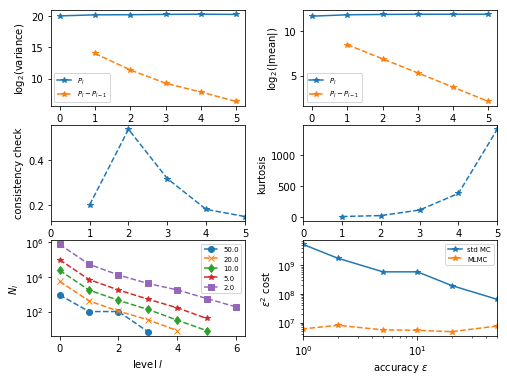

In [43]:
mlmc_plot(filename, nvert=3)
plt.savefig(filename.replace('.txt', '.eps'))